In [65]:
%matplotlib inline
import numpy as N
import matplotlib.pyplot as P
import time
import os
import matplotlib.cm as cm
from scipy.stats import kde
import matplotlib.colors as mcolors
from scipy.stats import mode
from scipy.interpolate import interp2d
from astropy.table import Table, Column, vstack, join
import astropy.units as un
from scipy.stats import binned_statistic_2d as bs2d
from scipy.stats import binned_statistic as bs


In [3]:
from astropy.cosmology import FlatLambdaCDM
#cosmo = FlatLambdaCDM(H0 = 71.0, Om0 = 0.26)
cosmo = FlatLambdaCDM(H0 = 75.0, Om0 = 0.3)
c = 299792.458 * un.km/un.s

In [130]:
#import os
#os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

P.rc('figure', facecolor='none', edgecolor='none', autolayout=True)
P.rc('path', simplify=True)
P.rc('text', usetex=False)
P.rc('font', family='serif')
P.rc('axes', labelsize='large', facecolor='none', linewidth=0.7, color_cycle = ['k', 'r', 'g', 'b', 'c', 'm', 'y'])
P.rc('xtick', labelsize='medium')
P.rc('ytick', labelsize='medium')
P.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
P.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
P.rc('savefig', facecolor='none', edgecolor='none', frameon='False')

params =   {'font.size' : 14,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
P.rcParams.update(params) 

In [5]:
data = Table.read('berlind_data_gz2_extra_order_sfh_samples_MPA_JHU.fits', format='fits')

In [12]:
field = Table.read('field_cand_sample_matched_cent_groups_stellar_mass_bins_0.2_sfr_h_alpha_masses_balrdy_env_lt_-0.8_gt_-999_rv_gtr_25_bestfit_t_tau_MPA_JHU.fits', format='fits')

In [208]:
sat_idx = N.where(N.logical_and(N.logical_and(data['AVG_SFR'] < data['peng']-0.3, data['t01_smooth_or_features_a01_smooth_debiased']>=0), N.logical_and(data['number in cluster']>1, data['central or satellite']==0)))
cent_idx = N.where(N.logical_and(N.logical_and(data['AVG_SFR'] < data['peng']-0.3,data['t01_smooth_or_features_a01_smooth_debiased']>=0), N.logical_and(data['number in cluster']>1, data['central or satellite']==1)))
field_idx = N.where(N.logical_and(field['AVG_SFR'] < field['peng']-0.3, field['t01_smooth_or_features_a01_smooth_debiased']>=0))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [209]:
qsat = data[sat_idx]
qcent = data[cent_idx]
qfield = field[field_idx] 

In [210]:
qfield['best fit t', 'plus error t', 'minus error t']

best fit t,plus error t,minus error t
Gyr,Gyr,Gyr
float64,float64,float64
12.4277471282,12.6502981921,11.9986045614
11.9700429955,12.3001235666,11.406143312
5.71019040933,9.13665885975,1.9463238066
4.24552069579,5.81345277235,3.3136145346
11.3734764078,11.9969968061,10.4327427662
2.4237826189,4.69451399099,0.737379691488
11.9429126563,12.5375744275,10.9737841472
11.2848258978,11.8338451662,10.1104834137


In [211]:
sat_t_since = cosmo.age(qsat['REDSHIFT']).value - qsat['best fit t']
sat_t_since_min = cosmo.age(qsat['REDSHIFT']).value - (qsat['best fit t'] + qsat['plus error t'])
sat_t_since_max = cosmo.age(qsat['REDSHIFT']).value - (qsat['best fit t'] - qsat['minus error t'])
cent_t_since = cosmo.age(qcent['REDSHIFT']).value - qcent['best fit t']
cent_t_since_min = cosmo.age(qcent['REDSHIFT']).value - (qcent['best fit t'] + qcent['plus error t'])
cent_t_since_max = cosmo.age(qcent['REDSHIFT']).value - (qcent['best fit t'] - qcent['minus error t'])
field_t_since = cosmo.age(qfield['z_1']).value - qfield['best fit t']
field_t_since_min = cosmo.age(qfield['z_1']).value - qfield['plus error t']
field_t_since_max = cosmo.age(qfield['z_1']).value - qfield['minus error t']

In [212]:
field_t_since

-0.0684869825937
0.306178795919
6.58538944919
8.10407772111
0.867507471082
9.87289769845
0.417791022485
1.00713104024
1.90920583649
9.42780369378
9.73140125321


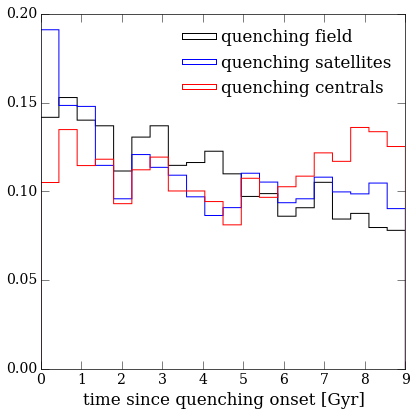

In [214]:
P.figure(figsize=(6,6))
ax = P.subplot(111)
ax.hist(field_t_since, bins=20, range=(0, 9), histtype='step', color='k', normed=True, label='quenching field')
ax.hist(sat_t_since, bins=20, range=(0, 9), histtype='step', color='b', normed=True, label='quenching satellites')
ax.hist(cent_t_since, bins=20, range=(0, 9), histtype='step', color='r', normed=True, label='quenching centrals')
ax.set_xlabel(r'time since quenching onset [Gyr]')
ax.legend(frameon=False)
P.savefig('time_since_quenching_compare.png')

In [215]:
#mc_bins = N.arange(9, 12, 0.5)
mc_bins = N.array([9, 10.5, 11, 12])
#m_bins = N.arange(9, 12, 0.5)
m_bins = N.array([9, 10.5, 11, 12])
N_bins = N.array([2, 10, 20, 400])
r_bins = N.append(N.append(N.linspace(0.1, 1, 6),  N.linspace(2, 14, 6), axis=0), 400)

In [216]:
bs_m_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass'], sat_t_since, bins=(r_bins, m_bins), statistic='median')
bs_m_qsat_min, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass'], sat_t_since_min, bins=(r_bins, m_bins), statistic='median')
bs_m_qsat_max, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass'], sat_t_since_max, bins=(r_bins, m_bins), statistic='median')
bs_mc_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass of group central'], sat_t_since, bins=(r_bins, mc_bins), statistic='median')
bs_N_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['number in cluster'], sat_t_since, bins=(r_bins, N_bins), statistic='median')

In [217]:
bs_m_qcent, x, n = bs(qcent['stellar mass'], cent_t_since, bins=m_bins, statistic='median')
bs_m_qcent_min, x, n = bs(qcent['stellar mass'], cent_t_since_min, bins=m_bins, statistic='median')
bs_m_qcent_max, x, n = bs(qcent['stellar mass'], cent_t_since_max, bins=m_bins, statistic='median')
bs_mc_qcent, x, n = bs(qcent['stellar mass of group central'], cent_t_since, bins=mc_bins, statistic='median')
bs_N_qcent, x, n = bs(qcent['number in cluster'], cent_t_since, bins=N_bins, statistic='median')

In [218]:
bs_m_qfield, x, n = bs(qfield['stellar mass'], field_t_since, bins=m_bins, statistic='median')
bs_m_qfield_min, x, n = bs(qfield['stellar mass'], field_t_since_min, bins=m_bins, statistic='median')
bs_m_qfield_max, x, n = bs(qfield['stellar mass'], field_t_since_max, bins=m_bins, statistic='median')
bs_mc_qfield, x, n = bs(qfield['stellar mass'], field_t_since, bins=mc_bins, statistic='median')
bs_N_qfield = N.ones_like(bs_mc_qfield)*N.median(field_t_since)

In [219]:
colours = ['blue', 'green', 'red']

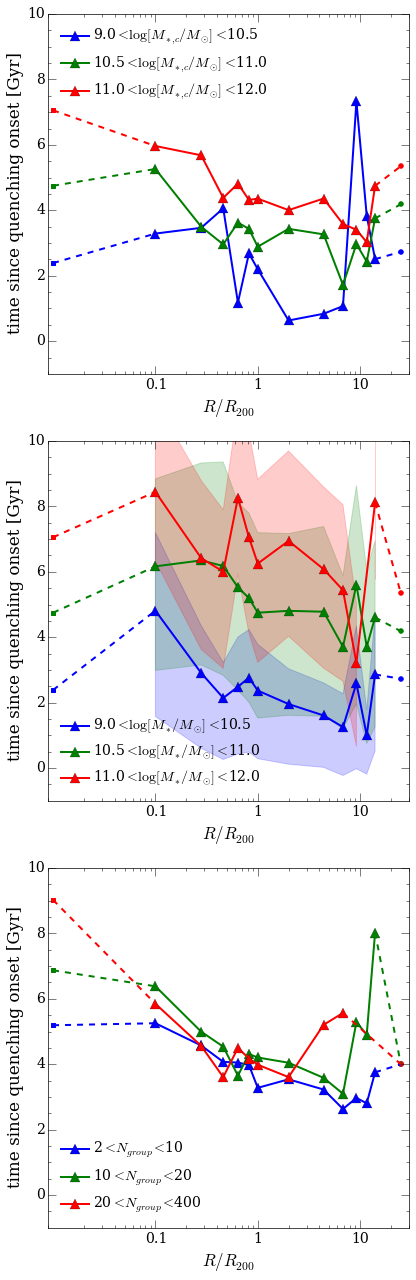

In [220]:
P.figure(figsize=(6, 18))
ax1 = P.subplot(311)
for n in range(len(mc_bins)-1):
    ax1.plot(r_bins[:-1], bs_mc_qsat[:,n], marker='^', ms=10, color=colours[n], label=r''+str(mc_bins[n])+'$ < \log [M_{*,c}/M_{\odot}] < $'+str(mc_bins[n+1]), linewidth=2)
    ax1.plot([0.01, r_bins[0]], [bs_mc_qcent[n], bs_mc_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_mc_qsat[-1,n], bs_mc_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_mc_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_mc_qfield[n], marker='o', s=20, color=colours[n])
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(-1, 10)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
ax1.legend(frameon=False, loc=2, fontsize=14)
ax1 = P.subplot(312)
for n in range(len(m_bins)-1):
    ax1.plot(r_bins[:-1], bs_m_qsat[:,n], marker='^', ms=10,color=colours[n], label=r''+str(m_bins[n])+'$ < \log [M_*/M_{\odot}] < $'+str(m_bins[n+1]), linewidth=2)
    ax1.fill_between(r_bins[:-1], y1=bs_m_qsat_min[:,n], y2=bs_m_qsat_max[:,n], color=colours[n], alpha=0.2)
    ax1.plot([0.01, r_bins[0]], [bs_m_qcent[n], bs_m_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_m_qsat[-1,n], bs_m_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_m_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_m_qfield[n], marker='o', s=20, color=colours[n])
ax1.plot([r_bins[-4], r_bins[-2]], [bs_m_qsat[-3,n], bs_m_qsat[-1,n]], marker='None', color=colours[n], linewidth=2)
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(-1, 10)
ax1.legend(frameon=False, loc=3, fontsize=14)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
ax1 = P.subplot(313)
for n in range(len(N_bins)-1):
    ax1.plot(r_bins[:-1], bs_N_qsat[:,n], marker='^',ms=10, color=colours[n], label=r''+str(N_bins[n])+'$ < N_{group} < $'+str(N_bins[n+1]), linewidth=2)
    ax1.plot([0.01, r_bins[0]], [bs_N_qcent[n], bs_N_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_N_qsat[-1,n], bs_N_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_N_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_N_qfield[n], marker='o', s=20, color=colours[n])
ax1.plot([r_bins[-5], 25], [bs_N_qsat[-4,n], bs_N_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(-1, 10)
ax1.legend(frameon=False, loc=3, fontsize=14)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('time_since_quenching_environment_properties.pdf')

In [189]:
bs_m_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass'], qsat['best fit tau'], bins=(r_bins, m_bins), statistic='median')
bs_mc_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['stellar mass of group central'], qsat['best fit tau'], bins=(r_bins, mc_bins), statistic='median')
bs_N_qsat, x, y, n = bs2d(qsat['projected cluster centric radius'].to(un.Mpc)/qsat['virial radius'], qsat['number in cluster'], qsat['best fit tau'], bins=(r_bins, N_bins), statistic='median')

In [190]:
bs_m_qcent, x, n = bs(qcent['stellar mass'], qcent['best fit tau'], bins=m_bins, statistic='median')
bs_mc_qcent, x, n = bs(qcent['stellar mass of group central'], qcent['best fit tau'], bins=mc_bins, statistic='median')
bs_N_qcent, x, n = bs(qcent['number in cluster'], qcent['best fit tau'], bins=N_bins, statistic='median')

In [191]:
bs_m_qfield, x, n = bs(qfield['stellar mass'], qfield['best fit tau'], bins=m_bins, statistic='median')
bs_mc_qfield, x, n = bs(qfield['stellar mass'], qfield['best fit tau'], bins=mc_bins, statistic='median')
bs_N_qfield = N.ones_like(bs_mc_qfield)*N.median(qfield['best fit tau'])

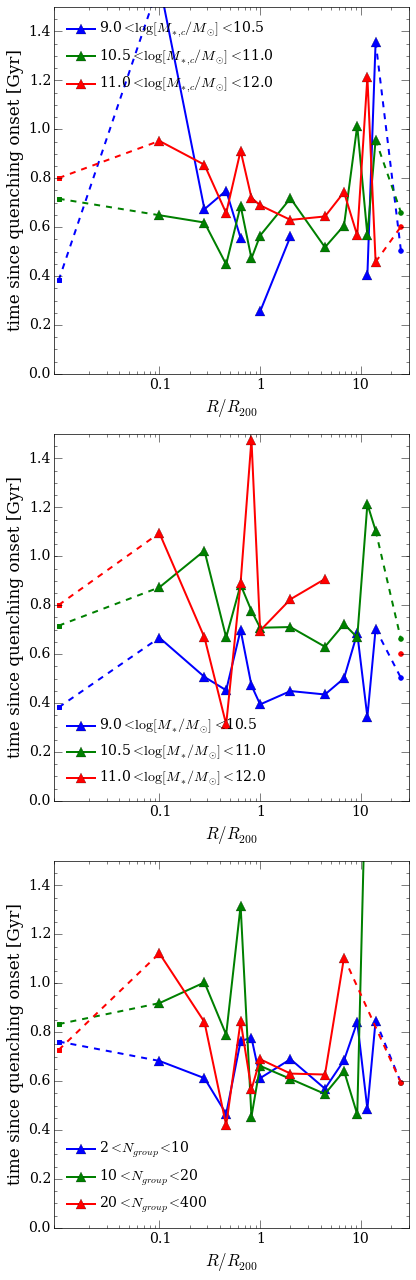

In [193]:
P.figure(figsize=(6, 18))
ax1 = P.subplot(311)
for n in range(len(mc_bins)-1):
    ax1.plot(r_bins[:-1], bs_mc_qsat[:,n], marker='^', ms=10, color=colours[n], label=r''+str(mc_bins[n])+'$ < \log [M_{*,c}/M_{\odot}] < $'+str(mc_bins[n+1]), linewidth=2)
    ax1.plot([0.01, r_bins[0]], [bs_mc_qcent[n], bs_mc_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_mc_qsat[-1,n], bs_mc_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_mc_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_mc_qfield[n], marker='o', s=20, color=colours[n])
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(0, 1.5)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
ax1.legend(frameon=False, loc=2, fontsize=14)
ax1 = P.subplot(312)
for n in range(len(m_bins)-1):
    ax1.plot(r_bins[:-1], bs_m_qsat[:,n], marker='^', ms=10,color=colours[n], label=r''+str(m_bins[n])+'$ < \log [M_*/M_{\odot}] < $'+str(m_bins[n+1]), linewidth=2)
    ax1.plot([0.01, r_bins[0]], [bs_m_qcent[n], bs_m_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_m_qsat[-1,n], bs_m_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_m_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_m_qfield[n], marker='o', s=20, color=colours[n])
ax1.plot([r_bins[-4], r_bins[-2]], [bs_m_qsat[-3,n], bs_m_qsat[-1,n]], marker='None', color=colours[n], linewidth=2)
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(0, 1.5)
ax1.legend(frameon=False, loc=3, fontsize=14)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
ax1 = P.subplot(313)
for n in range(len(N_bins)-1):
    ax1.plot(r_bins[:-1], bs_N_qsat[:,n], marker='^',ms=10, color=colours[n], label=r''+str(N_bins[n])+'$ < N_{group} < $'+str(N_bins[n+1]), linewidth=2)
    ax1.plot([0.01, r_bins[0]], [bs_N_qcent[n], bs_N_qsat[0,n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.plot([r_bins[-2], 25], [bs_N_qsat[-1,n], bs_N_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
    ax1.scatter(0.01, bs_N_qcent[n], marker='s', s=20, color=colours[n])
    ax1.scatter(25, bs_N_qfield[n], marker='o', s=20, color=colours[n])
ax1.plot([r_bins[-5], 25], [bs_N_qsat[-4,n], bs_N_qfield[n]], marker='None', color=colours[n], linestyle='dashed', linewidth=2)
ax1.set_ylabel(r'time since quenching onset [Gyr]')
ax1.set_xlabel(r'$R/R_{200}$')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.set_xlim(0.009, 30)
ax1.set_ylim(0, 1.5)
ax1.legend(frameon=False, loc=3, fontsize=14)
ax1.set_xticks([0.1, 1, 10])
ax1.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('tau_quenching_environment_smooth_properties.pdf')